In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1. Imports necessary libraries

In [2]:
## Import Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

#2. Data Loading

In [3]:
## Data loading
## Load feature sequences (rolling windows)
X = np.load("/content/drive/MyDrive/data/datasave/rolling_window_sequences.npy")

# Load metadata (engine_id, cycle, RUL, etc.)
metadata = pd.read_csv("/content/drive/MyDrive/data/datasave/sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values

# Checking array shapes
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (17631, 30, 66)
Shape of y: (17631,)


#3. Train/Validation Split

In [4]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, random_state=42, test_size=0.2
)
# dataset shapes
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)

# Display samples
print("Shape of one training sample:", X_train[0].shape)
print("Sample RUL values:", y_train[:5])


Training set: (14104, 30, 66) (14104,)
Validation set: (3527, 30, 66) (3527,)
Shape of one training sample: (30, 66)
Sample RUL values: [ 74.  41.  43.  33. 101.]


#4. Define Model Architectures

In [5]:
model = Sequential([
    LSTM(
        64,
        activation="tanh",
        input_shape=(X.shape[1], X.shape[2]),
        return_sequences=False
    ), Dense(1)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#5. Instantiate and compile models

In [6]:
# Compiling and Summary
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        33,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

#6. Prepare datasets for training

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

#7. Setup callbacks

In [8]:
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint(
    "best_lstm_model.keras",
    save_best_only=True,
    monitor="val_loss",
    verbose=1
)

#8. Train and compare models

In [10]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stop, reduce_lr, model_ckpt]
)

Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 11536.4717
Epoch 1: val_loss improved from inf to 9280.18848, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 11533.2949 - val_loss: 9280.1885 - learning_rate: 0.0010
Epoch 2/50
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8902.5713
Epoch 2: val_loss improved from 9280.18848 to 7735.69531, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 8898.9004 - val_loss: 7735.6953 - learning_rate: 0.0010
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7454.3442
Epoch 3: val_loss improved from 7735.69531 to 6523.58740, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 7453.4702 - val_loss: 6523.5874 - learning_rate: 0.0010
Epoch 4/50
219/221 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6304.5820
Epoch 4: val_loss improved from 6523.58740 to 5534.15869, saving model to best_lstm_model.keras
221/221 ━━━━━━━━━━

#9. Plot training and validation loss curve function

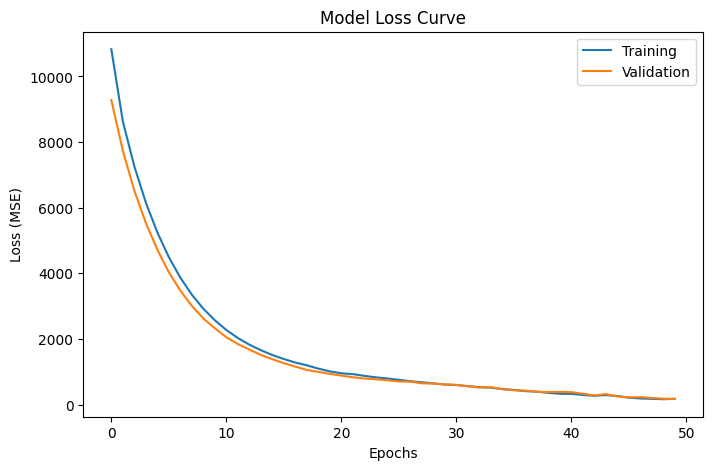

In [11]:
# Plot training and validation
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Training")
plt.plot(history.history["val_loss"], label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Model Loss Curve")
plt.legend()
plt.show()

#10. Provide Final Report of this Experiement.

### LSTM Model Training Summary

Built a regression model for RUL prediction using:

* LSTM layer with 64 units and tanh activation.

* Dense output layer to produce the final RUL value.

 The model was compiled using the Adam optimizer with a learning rate of 0.001 and MSE loss.

* Training utilized three key callbacks:

* **EarlyStopping** (patience = 8) → stops training early if validation loss doesn’t improve.

* **ReduceLROnPlateau** (factor = 0.5, patience = 4) → lowers learning rate when validation loss stagnates.

* **ModelCheckpoint** → stores the best-performing model in best_lstm_model.keras.

Model was trained for 50 epochs with a batch size of 64.

Training and validation curves showed consistent decline in loss, suggesting that the model learned effectively without severe overfitting.

## Model Performance
* The training and validation loss curves confirm the model's ability to learn temporal dependencies and generalize well.

* The best model checkpoint was saved for downstream evaluation and deployment.